## <span style='color: green'>PREPARE/DESCRIBE </span> Find Key Terms - Semantic Network<span style='float: right; color: green'>WORK IN PROGRESS</span>



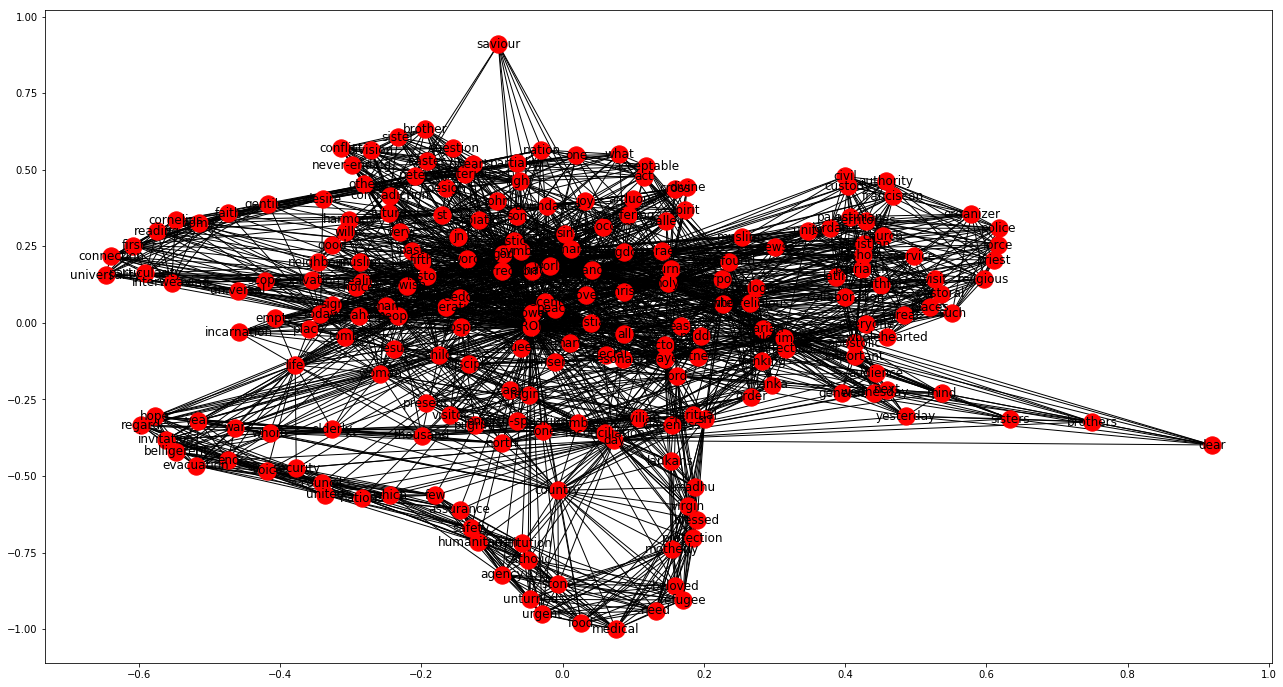

In [55]:
doc
normalize='lemma'
window_width=2
edge_weighting='binary'
ranking_algo='pagerank'
join_key_words=False,
n_keyterms=10


if isinstance(n_keyterms, float):
    if not 0.0 < n_keyterms <= 1.0:
        raise ValueError('`n_keyterms` must be an int, or a float between 0.0 and 1.0')
    n_keyterms = int(round(len(doc) * n_keyterms))

    
include_pos = {'NOUN', 'PROPN', 'ADJ'}
word_list = textacy.extract.words()
if normalize == 'lemma':
    word_list = [word.lemma_ for word in doc]
    good_word_list = [word.lemma_ for word in doc
                      if not word.is_stop and not word.is_punct and word.pos_ in include_pos]
elif normalize == 'lower':
    word_list = [word.lower_ for word in doc]
    good_word_list = [word.lower_ for word in doc
                      if not word.is_stop and not word.is_punct and word.pos_ in include_pos]
elif not normalize:
    word_list = [word.text for word in doc]
    good_word_list = [word.text for word in doc
                      if not word.is_stop and not word.is_punct and word.pos_ in include_pos]
else:
    word_list = [normalize(word) for word in doc]
    good_word_list = [normalize(word) for word in doc
                      if not word.is_stop and not word.is_punct and word.pos_ in include_pos]

good_word_list = [word for word in good_word_list if word]

graph = network.terms_to_semantic_network(good_word_list, window_width=window_width, edge_weighting=edge_weighting)

# rank nodes by algorithm, and sort in descending order
if ranking_algo == 'pagerank':
    word_ranks = nx.pagerank_scipy(graph, weight='weight')
elif ranking_algo == 'divrank':
    word_ranks = rank_nodes_by_divrank(graph, r=None, lambda_=kwargs.get('lambda_', 0.5), alpha=kwargs.get('alpha', 0.5))
elif ranking_algo == 'bestcoverage':
    word_ranks = rank_nodes_by_bestcoverage(graph, k=n_keyterms, c=kwargs.get('c', 1), alpha=kwargs.get('alpha', 1.0))

# bail out here if all we wanted was key *words* and not *terms*
if join_key_words is False:
    return [(word, score) for word, score in sorted(word_ranks.items(), key=operator.itemgetter(1), reverse=True)[:n_keyterms]]

top_n = int(0.25 * len(word_ranks))
top_word_ranks = { word: rank for word, rank in sorted(word_ranks.items(), key=operator.itemgetter(1), reverse=True)[:top_n] }

# join consecutive key words into key terms
seen_joined_key_terms = set()
joined_key_terms = []
for key, group in itertools.groupby(word_list, lambda word: word in top_word_ranks):
    if key is True:
        words = list(group)
        term = ' '.join(words)
        if term in seen_joined_key_terms:
            continue
        seen_joined_key_terms.add(term)
        joined_key_terms.append((term, sum(word_ranks[word] for word in words)))

return sorted(joined_key_terms, key=operator.itemgetter(1, 0), reverse=True)[:n_keyterms]


corpus = current_corpus()
doc = corpus[0]
include_pos = { 'NOUN', 'PROPN', 'ADJ' }
#exclude_pos = { 'PRON' }
window_width = 10
edge_weighting = 'cooc_freq'
#key_terms = textacy.keyterms.key_terms_from_semantic_network(
#    doc, normalize='lemma', window_width=4, edge_weighting='cooc_freq', ranking_algo='pagerank', join_key_words=False, n_keyterms=1000000
#)

terms = [x for x in textacy.extract.words(doc, filter_stops=True, filter_punct=True, filter_nums=False, include_pos=include_pos, exclude_pos=exclude_pos, min_freq=1)]
graph = textacy.network.terms_to_semantic_network(terms, normalize='lemma', window_width=window_width, edge_weighting=edge_weighting)
nodes = [{'name': str(i)} for i in graph.nodes(data=True)]
links = [{'source': u[0], 'target': u[1], 'weight': u[2] } for u in graph.edges(data='weight')]

import json
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(22, 12));
nx.draw_networkx(graph, ax=ax)


In [100]:
import glove
import numpy as np
import pandas as pd
pd.set_option('max_columns', 20)
pd.set_option('precision', 2)

def m2df(matrix, columns):
    return pd.DataFrame(
        data=matrix,
        index=list(columns),
        columns=list(columns)
    )

corpus_words = ['the', 'basic', 'concept', 'of', 'the', 'word', 'association']

token2id = { }
for w in corpus_words:
    if w not in token2id:
        token2id[w] = len(token2id)
                            
id2token = { k:w for w, k in token2id.items() }
columns = [ id2token[i] for i in range(0, len(id2token))]

print(token2id)
print(id2token)

#id2word = { k: w for w,k in dictionary.items() }

corpus = [corpus_words, corpus_words]

model = glove.Corpus(dictionary=dictionary)
model.fit(corpus, window=5)

X = model.matrix.astype(np.float64)

Xi = X.sum(axis=1)
Pij = (X / Xi)
Pij[np.isnan(Pij)] = 0
Pji = Pij.T

print(m2df(model.matrix.todense(), columns))
print(m2df(Pij, columns))
print(m2df(Pji, columns))
print(m2df(Pij+Pji, columns))

Pij.sum(axis=1)

#print(model.dictionary)

#Pij = np.divide(X, Xi, out=np.zeros_like(X), where=Xi!=0)
    
#for word in corpus_words:
#    assert word in model.dictionary

#assert model.matrix.shape == (len(corpus_words), len(corpus_words))

#expected = [[0.0, 1.0, 0.5],
#            [0.0, 0.0, 1.0],
#            [0.0, 0.0, 0.0]]

#assert (model.matrix.todense().tolist() == expected)


{'basic': 1, 'the': 0, 'concept': 2, 'association': 5, 'of': 3, 'word': 4}
{0: 'the', 1: 'basic', 2: 'concept', 3: 'of', 4: 'word', 5: 'association'}
             the  basic  concept    of  word  association
the          0.0   2.67      2.0  2.67  2.40         1.00
basic        0.0   0.00      2.0  1.00  0.50         0.40
concept      0.0   0.00      0.0  2.00  0.67         0.50
of           0.0   0.00      0.0  0.00  1.00         0.67
word         0.0   0.00      0.0  0.00  0.00         2.00
association  0.0   0.00      0.0  0.00  0.00         0.00
             the  basic  concept    of  word  association
the          0.0   0.25     0.19  0.25  0.22         0.09
basic        0.0   0.00     0.51  0.26  0.13         0.10
concept      0.0   0.00     0.00  0.63  0.21         0.16
of           0.0   0.00     0.00  0.00  0.60         0.40
word         0.0   0.00     0.00  0.00  0.00         1.00
association  0.0   0.00     0.00  0.00  0.00         0.00
              the  basic  concept   of

matrix([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.]])

\begin{aligned}
p(A, B, k) &= \frac{cooccurrence(A, B, K)}{count(A)}
\end{aligned}